This notebook is intended to introduce you to running ipython notebook and to familiarize you with some basics of numpy, matplotlib, and sklearn, which you'll use extensively in this course. Read through the commands, try making changes, and make sure you understand how the plots below are generated.

In your projects, you should focus on making your code as readable as possible. Use lots of comments -- see the code below -- and try to prefer clarity over compact code.

You should also familiarize yourself with the various keyboard shortcuts for moving between cells and running cells. Ctrl-ENTER runs a cell, while shift-ENTER runs a cell and advances focus to the next cell.

## Imports

The first code cell just contains setup calls -- importing libraries and some other global settings to make things run smoothly.

In [1]:
# Import a bunch of libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

## Sample Data

Generate evenly spaced X values in [0,1] using linspace.
X is a numpy array, in particular a multi-dimensional "ndarray".
Try looking at the documentation for ndarray:
http://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html

In [5]:
# How many samples to generate. Try adjusting this value.
n_samples = 21

# Evenly spaced
X = np.linspace(0, 1, n_samples)

# Inspect X.
print(X)
print(type(X))
print(X.shape)

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
<class 'numpy.ndarray'>
(21,)


In [3]:
?np.linspace

Let's create a "true" function that we will try to approximate with a model, below. We'll use python's lambda syntax, which makes it easy to define a simple function in a single line. See here for more details:

http://www.python-course.eu/lambda.php


In [7]:
# Set the true function as a piece of a cosine curve.
true_function = lambda x: np.cos(1.5 * np.pi * x)

# Try it out. Notice that you can apply the function to a scalar or an array.
print(true_function(0))
print(true_function(0.5))
print(true_function(np.array([0, 0.5])))

1.0
-0.707106781187
[ 1.         -0.70710678]


In [9]:
?np.cos



-0.952412980415


Now, let's generate noisy observations of our true function. This simulates something like the situation we encounter in the real world: we observe noisy data from which we'd like to infer a model.

In [10]:
# Generate true y values.
y = true_function(X)

# Print the values of y to the nearest hundredth.
print(['%.2f' %i for i in y])

# Add random noise to y.
# The randn function samples random numbers from the standard Normal distribution.
# Multiplying adjusts the standard deviation of the distribution.
y += np.random.randn(n_samples) * 0.2

# Print the noise-added values of y for comparison.
print(['%.2f' %i for i in y])

['1.00', '0.97', '0.89', '0.76', '0.59', '0.38', '0.16', '-0.08', '-0.31', '-0.52', '-0.71', '-0.85', '-0.95', '-1.00', '-0.99', '-0.92', '-0.81', '-0.65', '-0.45', '-0.23', '-0.00']
['0.91', '0.44', '0.81', '0.66', '0.50', '0.33', '0.04', '-0.27', '0.16', '-1.00', '-0.63', '-0.65', '-1.22', '-1.03', '-1.13', '-0.93', '-0.94', '-0.85', '-0.62', '-0.09', '-0.29']


Ok. Now we have some outputs, y, that we want to predict, and some inputs X. In general, our outputs (in this course) will always be 1-dimensional. Our inputs will usually have more than 1 dimension -- we'll call these our features. But here, for simplicity, we have just a single feature. 

Since the machine learning classes in sklearn expect input feature vectors, we need to turn each input x in X into a feature vector [x].

In [11]:
# Another way to do this is np.transpose([X]). Read more about array indexing for details.
X = X[:, np.newaxis]
print(X)
print(X.shape)

[[ 0.  ]
 [ 0.05]
 [ 0.1 ]
 [ 0.15]
 [ 0.2 ]
 [ 0.25]
 [ 0.3 ]
 [ 0.35]
 [ 0.4 ]
 [ 0.45]
 [ 0.5 ]
 [ 0.55]
 [ 0.6 ]
 [ 0.65]
 [ 0.7 ]
 [ 0.75]
 [ 0.8 ]
 [ 0.85]
 [ 0.9 ]
 [ 0.95]
 [ 1.  ]]
(21, 1)


### Exercise

We're going to use lots of samples like this. Let's write a function to automate the process.

In [18]:
def generate_sample_data(nsamp, true_function):
    """Noisy samples of true_function on the interval (0,1)
    
    Args: 
        nsamp: number of evenly spaced samples on (0,1)
        true_function: function to apply to each sample
        
    Returns:
        X: evenly space points on (0,1) as a column vector
        actual: the value of true_function at each point in X
        y: function values with noise added
    """
    
    # Insert your code here
    X = np.linspace(0, 1, nsamp)
    actual = true_function(X)
    y = actual
    y += np.random.randn(nsamp) * 0.2
    X = np.transpose([X])
    y = np.transpose([y])
    actual = np.transpose([actual])
    # return X, actual, y
    return X, actual, y


##### Test

In [19]:
generate_sample_data(10, true_function)

(array([[ 0.        ],
        [ 0.11111111],
        [ 0.22222222],
        [ 0.33333333],
        [ 0.44444444],
        [ 0.55555556],
        [ 0.66666667],
        [ 0.77777778],
        [ 0.88888889],
        [ 1.        ]]), array([[ 0.78974625],
        [ 0.80888475],
        [ 0.42614663],
        [ 0.02152827],
        [-0.55122677],
        [-0.95111479],
        [-0.85443853],
        [-1.05107588],
        [-0.87558948],
        [ 0.44931459]]), array([[ 0.78974625],
        [ 0.80888475],
        [ 0.42614663],
        [ 0.02152827],
        [-0.55122677],
        [-0.95111479],
        [-0.85443853],
        [-1.05107588],
        [-0.87558948],
        [ 0.44931459]]))

## Linear Regression

Since you're already familiar with linear regression, let's try that first. Check out the sklearn documentation for linear regression:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [23]:
# Try setting fit_intercept=False as well.
X, actual, y = generate_sample_data(20, true_function)
lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)
print(lr.intercept_)
print(lr.coef_)
print('Estimated function: y = %.2f + %.2fx' %(lr.intercept_, lr.coef_[0]))

[ 0.71633956]
[[-1.74911759]]
Estimated function: y = 0.72 + -1.75x


Let's take a look at what is happening graphically. Here is a function to compare actual and fitted values.

In [27]:
def compare_fitted_function(X, y, actual, model):
    """Plot actual vs fitted values of model"""
    plt.scatter(X, y, label = 'Samples')
    plt.plot(X, actual, label = 'True Function')
    plt.plot(X, model.predict(X), label = 'Model')
    plt.legend(loc='best', fontsize='x-small')
    plt.setp(plt.gca(), xticks=(), yticks=())
    plt.xlim(-.05, 1.05)

Generate some data, fit a linear regression model, and plot the results.

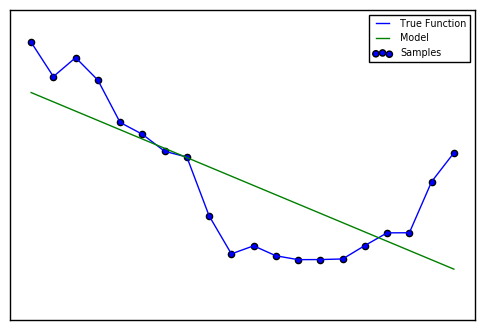

In [28]:
X, actual, y = generate_sample_data(20, true_function)
lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)
compare_fitted_function(X, y, actual, lr)

A linear model doesn't work too well for fitting this data - it just isn't complex enough. 

### Exercise

Repeat the process above for five _different_ samples of 20 points. Place the plots side by side.

In [ ]:
nsamp = 20
plt.figure(figsize=(14, 4))

for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    
    # Your code goes here


The linear model has ___high bias___
- The model is always wrong, even when you try different training data. In fact, it's always wrong _in the same way_.
- The model does not have enough complexity to match the underlying function.
- This is an example of underfitting

On the other hand, the model exhibits ___low variance___.
- The learned model is basically the same, no matter which (random) sample is used.

## Polynomial Regression

Approximating a cosine function with a linear model doesn't work so well. By adding polynomial transformations of our feature(s), we can fit more complex functions. This is often called polynomial regression. Take a look at the sklearn documentation for the PolynomialFeatures preprocessor:

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

You'll notice that the sklearn classes have many of the same function names like fit() and fit_transform().

In [ ]:
# Try increasing the degree past 2.
poly = PolynomialFeatures(degree=2, include_bias=False)
X2 = poly.fit_transform(X)
print X2

Now let's fit a linear model where the input features are (x, x^2).

In [ ]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X2, y)
print lr.intercept_
print lr.coef_
print 'Estimated function: y = %.2f + %.2fx0 + %.2fx1' %(lr.intercept_, lr.coef_[0], lr.coef_[1])

We can use sklearn's Pipeline framework to connect the polynomial expansion and the linear regression into one 'model'

In [ ]:
degree = 2
poly = PolynomialFeatures(degree = degree, include_bias=False)
lr = LinearRegression(fit_intercept=True)
pipeline = Pipeline([("polynomial_features", poly),
                     ("linear_regression", lr)])
pipeline.fit(X, y)
compare_fitted_function(X, y, true_function(X), pipeline)

What is the best degree of polynomial to use? What happens when the degree is too high?

### Exercise: Generate 5 model comparison plots. For each plot,
- Generate 20 evenly spaced (noisy) samples
- Fit a 10 degree polynomial to the sample.
- Plot the fitted vs actual values

In [ ]:
# Your code goes here


The degree 10 polynomial model has ___high variance___
- Slightly different training sets result in very different models.
- This is an example of overfitting
- Models with high variance do not generalize well. That is, since training data is different from testing data, a model that is optimal for the training data could be very different from the model that would have been optimal for the test data.

On the other hand, the model exhibits ___low bias___.
- A 10 degree polynomial is plenty complex to model the underlying function.
- In fact, if you were to carry out the above process 1000s of times, you would see that _on average_ the model predictions match the actual values. (Try it!)

### Questions

- What happens to a high bias model when you add more training data? What about a high variance model?

## Bonus

Machine learning is a constant battle with the _bias-variance tradeoff_. Simple models tend to be biased, but as we add complexity to reduce the bias, we also increase the variance---which can lead to overfitting.

Let's explore this concept to find the optimal degree of polynomial to fit 20 samples from a cosine curve.

#### 1. Write a function that returns training and testing error

Hint: Try looking at the predict method in the LinearRegression object

In [ ]:
def get_error(X, y, actual, model):
    """Get training and testing error
    
    Input:
        X: evenly spaced points on (0,1)
        y: noisy observations of the true function
        actual: true value of the function
        model: linear or polynomial regression model
        
    Returns:
        train_error: average squared error on the training data
        test_error: average squared error, compared to the true function
    """
    # Your code goes here
    
    # return train_error, test_error


##### Test

In [ ]:
get_error(X, y, actual, pipe)    

#### 2. Plot degree of polynomial vs train/test error

In [ ]:
train_errs = []
test_errs = []
X, actual, y = generate_sample_data(20, true_function)
degrees = range(1, 13)

for deg in degrees:
    
    # Fit a polynomial model
    # Your code goes here
    
    # Append the training and testing error
    # your code goes here
    

# Plot
plt.plot(degrees, train_errs, label='Training Error')
plt.plot(degrees, test_errs, label='True Error')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.show()

#### 3. Which degree of polynomial would you choose?

A 3rd degree polynomial is best. For some runs, the 4th degree polynomial has a slightly lower true error, but the gain is marginal. A simpler model is always preferred, when possible.